<a href="https://colab.research.google.com/github/Oliz888/voting_and_consensus/blob/main/voting_and_consensus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Setting up Google Colab (optional) ###
# Installing necessary packages
!pip install python-igraph
!pip install leidenalg
!pip install umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 4.2 MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.10.2-py3-none-any.whl size=9074 sha256=dbbae691cf4e8cdbd448f81db596be8cadf80f8e1c611f42162bbf791142241a
  Stored in directory: /root/.cache/pip/wheels/74/1d/33/83ec153aa37c92957b2edb888f4f42fdea9b7ac89f4b919391
Successfully built python-igraph
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 3.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=f3b7d74d16c985a07fa1a4cc17531fd70ef12d6e87aa4c26138d144688e58bc3
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from textwrap import wrap
from sklearn.neighbors import kneighbors_graph

import umap

import igraph as ig
import leidenalg

from sklearn.decomposition import PCA



In [3]:
# Getting access to Google Drive files (participants-votes.csv etc)
from google.colab import drive
drive.mount("/content/drive")

comments= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/comments.csv")
votes = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/participants-votes.csv")

Mounted at /content/drive


In [4]:
# examine the shape and head of df 
comments.shape
comments.head()
comments.dtypes

timestamp        int64
datetime        object
comment-id       int64
author-id        int64
agrees           int64
disagrees        int64
moderated        int64
comment-body    object
dtype: object

In [5]:
votes.shape
votes.head()


,participant,group-id,n-comments,n-votes,n-agree,n-disagree,0,1,2,3,...,187,188,189,190,191,192,193,194,195,196
0,0,0.0,46,101,44,12,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,29,14,10,1.0,-1.0,-1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1.0,5,88,58,15,1.0,-1.0,-1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1.0,0,31,13,16,1.0,-1.0,-1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1.0,0,11,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
comments.index = comments.index.astype(str)

In [7]:
# remove statements (columns) which were moderated out
statements_all_in = sorted(list(comments.loc[comments["moderated"] > 0].index.array), key = int)

In [8]:
## obtain the number of issues for votes 
metadata_fields = ['group-id', 'n-comments', 'n-votes', 
                   'n-agree', 'n-disagree']
val_fields = [c for c in votes.columns.values if c not in metadata_fields]

## there are 196 issues (comments left by other participants) for votes to opt

In [9]:
## for a row, count the number of finite values
def count_finite(row):
    finite = np.isfinite(row[val_fields]) # boolean array of whether each entry is finite
    return sum(finite) # count number of True values in `finite`


## REMOVE PARTICIPANTS WITH LESS THAN N VOTES check for each row if the number of finite values >= cutoff
def select_rows(df, threshold):
    
    number_of_votes = votes.apply(count_finite, axis=1)
    valid = number_of_votes >= threshold
    
    return votes[valid]

df_votes = select_rows(votes, 7)

In [10]:
metadata = df_votes[metadata_fields]
vals = df_votes[val_fields]
# If the participant didn't see the statement, it's a null value, here we fill in the nulls with zeros
vals = vals.fillna(0)
vals = vals.sort_values("participant")
vals 



,participant,0,1,2,3,4,5,6,7,8,...,187,188,189,190,191,192,193,194,195,196
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.0,-1.0,-1.0,1.0,1.0,0.0,-1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,4654,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,4655,0.0,0.0,0.0,-1.0,1.0,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1125,4659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1261,4661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
## calculating the variances for the column in vars to explore the degree of divergence in opinion 

val_variances = vals.drop("participant",axis=1).var()
df_variances = pd.DataFrame(val_variances)
df_variances.columns = ['val_var']
df_variances= df_variances.reset_index().astype(float)

df_variances['index']
comments['comment-id']


0      194
1      187
2      183
3      138
4      130
      ... 
192    191
193    192
194    193
195    195
196    196
Name: comment-id, Length: 197, dtype: int64

In [46]:
## merge the variances dataframe with the comment dataframe to obtain the attribute 
comments_var = comments.merge(df_variances, 
                              left_on = "comment-id",
                              right_on = "index")


In [47]:
# get the classfication of high variances and low variances comments 
comments_var = comments_var.sort_values(by = "val_var", ascending = False).reset_index()
df_high_variances = comments_var.head(10)
df_low_variances = comments_var.tail(10)



In [50]:
# obtain the list of comments that derive high variances and low variances respectively
high_variance = df_high_variances["level_0"].tolist()
statement_consensus = df_low_variances["level_0"].tolist()

In [51]:
high_variance

[179, 34, 35, 37, 170, 176, 49, 46, 171, 167]

In [52]:
statement_consensus

[11, 186, 73, 72, 1, 137, 59, 56, 45, 88]

In [ ]:
# get the list of comments used to construct opinion groups from: https://pol.is/report/r32beaksmhwesyum6kaur. 
statements_opiods_A = [18, 44, 19, 5, 6]
statements_opiods_B = [38, 18, 19, 44, 35]

In [56]:

vals_all_in = vals[statements_all_in]

# Overall Stats


How sparse is the dataset? How much agree, how much disagree, how much pass? Zero is 'passed' or 'did not see the comment to vote on it'. 1 is agree, -1 is disagree

In [54]:
melted = comments.melt();
all_votes = melted.count();
by_type = melted["value"].value_counts();
total_possible_votes = all_votes["value"];
total_agrees = by_type[1.0];
total_disagrees = by_type[-1.0];
total_without_vote = by_type[0.0];

print("Dimensions of matrix:", vals.shape)
print("Dimensions of matrix:", vals.shape)
print("Total number of possible votes:", total_possible_votes)
print("Total number of agrees:", total_agrees)
print("Total number of disagrees:", total_disagrees)
print("Total without vote:", total_without_vote)
print("Percent sparse: ", total_without_vote / total_possible_votes,"%")

## Make sure to check how many people and votes, relative to the total matrix, you are losing given min vote threshold

Dimensions of matrix: (1269, 198)
Dimensions of matrix: (1269, 198)
Total number of possible votes: 1576
Total number of agrees: 197
Total number of disagrees: 78
Total without vote: 163
Percent sparse:  0.1034263959390863 %


**Full participants * comments matrix**

Some things to notice about the matrix: comments are submitted over time, so participants who do not return will only have voted on the statements which were avialable when they arrived.

Long horizontal lines: participants who do return show up as a horizontal line sticking out into otherwise blank areas

Blank vertical lines: most likely statements which were moderated out of the conversation.

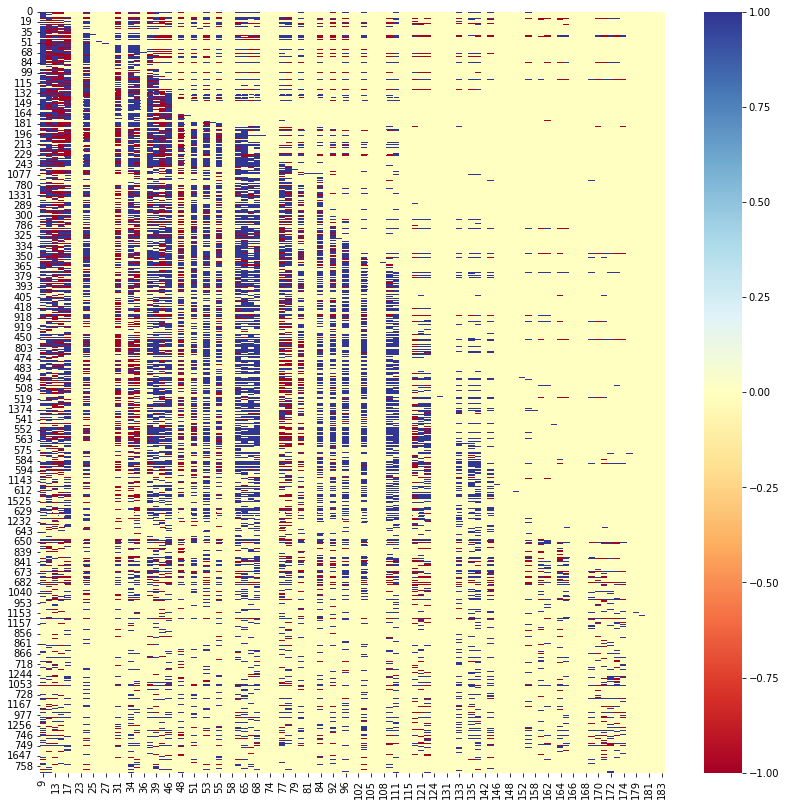

In [57]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(vals_all_in, center=0, cmap="RdYlBu", ax=ax)